In [344]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from MMD import mmd_rbf, mmd_linear, mmd_poly
from tsl.datasets import AirQuality, MetrLA, PemsBay
from GRGN.Engines.Generator import Generator
from GRGN.GRGNModel import GRGNModel
from GRGN.Loss.LogLikelihood import LogLikelihood
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
import matplotlib.pyplot as plt
import torch


In [345]:
filename = '/Users/paulmagos/Documents/TSGen/logs/generation/grgn1/best-model-epoch=07-val_loss=4.1683.ckpt'

In [346]:
dataset = PemsBay()

adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe()[-1100:],
                                    covariates=None,
                                    connectivity=adj,
                                    window=1,
                                    stride=1)
scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=8)
dm.setup(stage='test')

# if cfg.get('in_sample', False):
dm.trainset = list(range(len(torch_dataset)))

In [347]:
loss_fn = LogLikelihood(both=True)

log_metrics = {
    '1stLL': LogLikelihood(False),
    '2ndLL': LogLikelihood(True),
    '12LL': LogLikelihood(both=True),
}

# setup generator
generator = Generator.load_from_checkpoint(filename)

In [348]:
trainer = Trainer()

trainer.ckpt_path= filename

generator.freeze()
# trainer.test(generator, datamodule=dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [349]:
output = trainer.predict(generator, dataloaders=dm.test_dataloader())
output = generator.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
# res = dict(test_mae=loss_fn.loss(torch.tensor(y_hat), y_true))
# res

Restoring states from the checkpoint path at /Users/paulmagos/Documents/TSGen/logs/generation/grgn1/best-model-epoch=07-val_loss=4.1683.ckpt
Loaded model weights from the checkpoint at /Users/paulmagos/Documents/TSGen/logs/generation/grgn1/best-model-epoch=07-val_loss=4.1683.ckpt
/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0:   0%|          | 0/109 [00:00<?, ?it/s]

Only args ['x', 'edge_weight', 'edge_index'] are forwarded to the model (GRGNModel). 


Predicting DataLoader 0: 100%|██████████| 109/109 [00:07<00:00, 14.18it/s]


In [350]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)

In [351]:
M = 40
out = y_hat[..., :(1 + 2) * M]
out = scalers['target'].transform(out)
out = torch.tensor(out)    
D = out.shape[-1] // M - 2

means = out[..., :M*D]
stds  = out[..., M*D:M * (D+1)]
weights = out[..., M*(D+1):]

pred = weights * torch.normal(means, stds)
pred = torch.mean(pred, dim=-1)
pred = scalers['target'].inverse_transform(pred)

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_60468/479927568.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out)


In [352]:
X = y_true.reshape(y_true.shape[0], -1)
Y = pred.reshape(y_true.shape[0], -1)

In [353]:
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.01834862306714058

In [354]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

tensor(14327.0527)

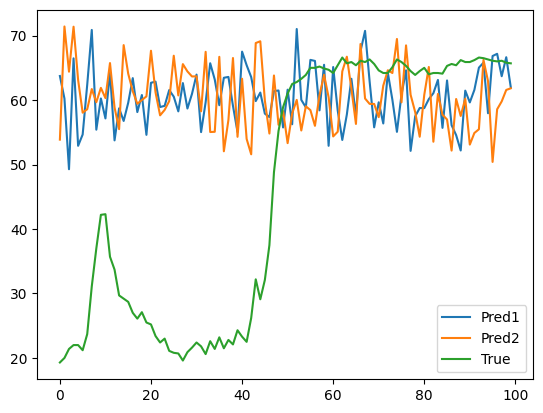

In [355]:
# plt.plot(Y[:100, 1], label='Pred')
# plt.plot(X[:100, 1], label='True')
plt.plot(Y[:100, 1], label='Pred1')
plt.plot(Y[:100, 2], label='Pred2')
plt.plot(X[:100, 1], label='True')
plt.legend()

In [421]:
y_true.shape

input = y_true[-100:-99]
input = scalers['target'].transform(input)
input.shape

torch.Size([1, 1, 325, 1])

In [422]:
generation, out = generator.generate(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), None, 'mean', 99, first_part=False)

In [423]:
generation = torch.cat(generation)
true = y_true.reshape(y_true.shape[0], y_true.shape[-2])
generation = generation.reshape(generation.shape[0], generation.shape[-2])
generation = scalers['target'].inverse_transform(generation)[0]
generation.shape

torch.Size([99, 325])

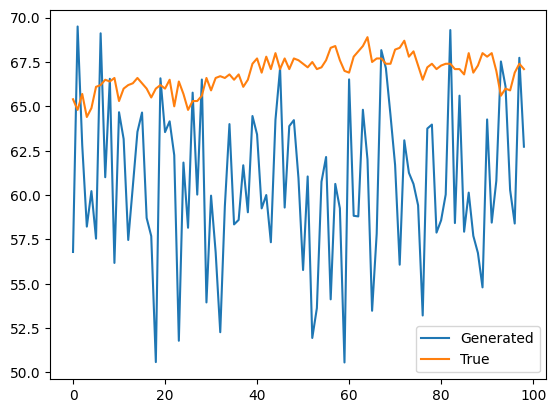

In [424]:
plt.plot(generation[:, 30], label='Generated')
plt.plot(true[-99:, 30], label='True')


plt.legend()

In [425]:
out = torch.cat(out)

out = out[..., :(1 + 2) * M]
out = torch.tensor(out)    
D = out.shape[-1] // M - 2

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_60468/435954874.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out)


In [426]:
means = out[..., :M*D]
stds  = out[..., M*D:M * (D+1)]
weights = out[..., M*(D+1):]

pred = weights * torch.normal(means, stds)
pred = torch.mean(pred, axis=-1)
pred = scalers['target'].inverse_transform(pred)

In [427]:
pred = pred.reshape(pred.shape[0], pred.shape[-1])


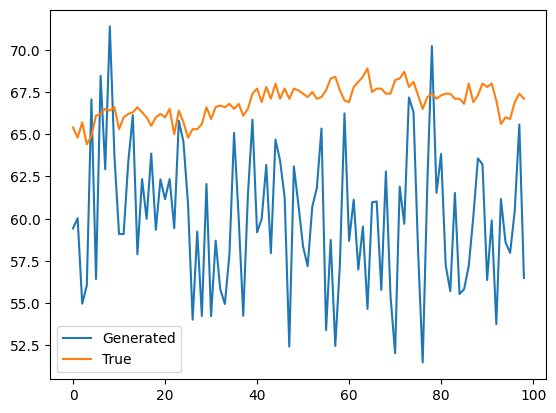

In [428]:
plt.plot(pred[:, 30], label='Generated')
plt.plot(true[-99:, 30], label='True')

# plt.plot(pred[:, 20], label='Generated50')
# plt.plot(true[-99:, 20], label='True50')
plt.legend()

In [429]:
X = true
Y = generation
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.019275322556495667

In [430]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))


tensor(14294.0146)

In [449]:
y_true.shape

input = y_true[-100:]
input = scalers['target'].transform(input)
input.shape

torch.Size([100, 1, 325, 1])

In [450]:
prediction, out = generator.predict(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), method='mean')

In [451]:
# prediction = torch.cat(prediction)
prediction1 = prediction.reshape(prediction.shape[0], prediction.shape[-1])*0.2
prediction = scalers['target'].inverse_transform(prediction1)[0]
prediction.shape

torch.Size([100, 325])

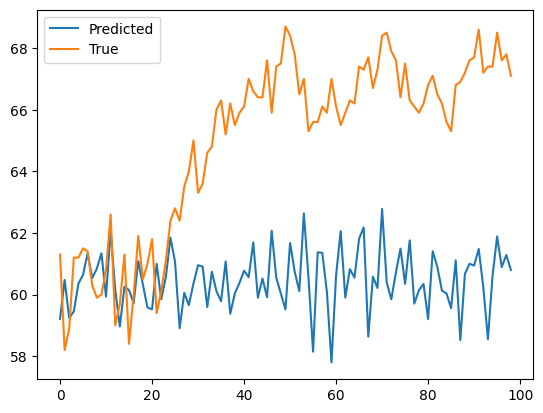

In [452]:
plt.plot(prediction[-99:, 10], label='Predicted')
plt.plot(true[-99:, 10], label='True')


# plt.plot(prediction[:, 100], label='Predicted')
# plt.plot(true[-99:, 100], label='True')
plt.legend()

In [453]:
X = true
Y = generation
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.019275322556495667

In [454]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))


tensor(14294.0146)